Load dependencies:

In [ ]:
!pip install opensmile
!pip install tensorflow_io
import os
import numpy as np
import librosa
import opensmile
import math
import scipy
import tensorflow as tf
import tensorflow_io as tfio

directory = "/content/drive/MyDrive/PatientVoiceAI/data"
model_dir = "/content/drive/MyDrive/PatientVoiceAI/saved_models"

Load and preprocess raw audio files in the dataset:

In [2]:
def preprocess(x, chunksize):
    x_len = len(x)
    if x_len < chunksize:   # padding
        # processed = np.pad(x, (0,chunksize-x_len))  # right-pad with zero
        processed = np.resize(x, (chunksize,))        # repeat padding
    elif x_len > chunksize: # splitting
        tailing = x_len % chunksize
        if tailing != 0:                # handle uneven splits: create overlap for the last chunk
            x = np.concatenate((x[:-tailing], x[-chunksize:]))
        num_chunks = int(round(len(x)/chunksize))
        processed = np.array_split(x,num_chunks)
    else:                   # no change
        processed = np.array(x)
    return processed

def get_dataset(label, label_index, chunksize):
    x_set = []
    folder = os.path.join(directory, label)
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f):
            audio, sample_rate = librosa.load(f)
            x_set.append(preprocess(audio,chunksize))
    x_set = np.vstack(x_set)
    y_set = np.repeat([label_index[label]],len(x_set))
    return x_set,y_set


classes = ["coughing", "sneezing", "speech", "silence"]

label_index = {
    "coughing":0,
    "sneezing":1,
    "speech":2,
    "silence":3
}

sample_rate = 22050   # default sample rate in librosa
chunksize = 5*sample_rate   # length in seconds * sampling rate


## initialise the dataset
x_set = []
y_set = []
for label in classes:
    x_subset, y_subset = get_dataset(label,label_index,chunksize)
    x_set.extend(x_subset)
    y_set.extend(y_subset)

x_set = np.asarray(x_set).astype('float32')
y_set = np.asarray(y_set)

print(np.shape(x_set))
print(x_set[0])
print(np.shape(y_set))
print(y_set[0])



(5051, 110250)
[ 0.03695566  0.04142303  0.01117673 ... -0.00433899 -0.0128603
 -0.02826079]
(5051,)
0


Define a function to get OpenSmile features:

In [ ]:
# Feature Level: Low Level Descriptors
# NOT USED
def get_features_llds(x, sr=sample_rate):
    smile_llds = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )
    llds = smile_llds.process_signal(x,sr)

    ## spectral features
    mfcc1 = np.array(llds['mfcc1_sma3'])
    flux = np.array(llds['spectralFlux_sma3'])
    # h1_a3 = np.array(llds['logRelF0-H1-A3_sma3nz'])
    # hammarberg =  np.array(llds['hammarbergIndex_sma3'])

    ## prosodic features
    loudness = np.array(llds['Loudness_sma3'])
    pitch = np.array(llds['F0semitoneFrom27.5Hz_sma3nz'])     # F0 envelope
    shimmer = np.array(llds['shimmerLocaldB_sma3nz'])
    jitter = np.array(llds['jitterLocal_sma3nz'])
    # hnr =  np.array(llds['HNRdBACF_sma3nz'])
    # f1freq = np.array(llds['F1frequency_sma3nz'])
    # f1band = np.array(llds['F1bandwidth_sma3nz'])
    # f1amp = np.array(llds['F1amplitudeLogRelF0_sma3nz'])
    # f2freq = np.array(llds['F2frequency_sma3nz'])
    # f3freq = np.array(llds['F3frequency_sma3nz'])

    ## create the feature vector
    feature = np.vstack((
        mfcc1,
        flux,          #
        # h1_a3,
        # hammarberg,
        loudness,
        pitch,          #
        jitter,
        shimmer,       #
        # hnr,
        # f1freq,
        # f1band,
        # f1amp,
        # f2freq,
        # f3freq,
        )).transpose()

    return feature


# x_set_features = []
# for x in x_set:
#     x_set_features.append(get_features_llds(x))
# x_set_features = np.asarray(x_set_features)
# print(np.shape(x_set_features))

(13143, 95, 6)


In [4]:
# Feature Level: Functionals
def get_functionals(x, sr=sample_rate):
    window_size = 1*sr
    step_size = int(0.5*sr)
    start_index = 0

    smile_functionals = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    functionals = []
    while (start_index+window_size) <= len(x):
        end_index = start_index+window_size
        x_slice = x[start_index:end_index]
        start_index += step_size

        functionals_slice = smile_functionals.process_signal(x_slice, sr)
        functionals.append(functionals_slice)
    return np.squeeze(functionals)


# testing:
# print(np.shape(get_functionals(x_set[0])))

counter=0
x_set_features = []
for x in x_set:
    x_set_features.append(get_functionals(x))
    if counter%100 == 0:
      print(f"progress: {counter}/{len(x_set)}")
    counter +=1
x_set_features = np.asarray(x_set_features)
print(np.shape(x_set_features))

progress: 0/5051
progress: 100/5051
progress: 200/5051
progress: 300/5051
progress: 400/5051
progress: 500/5051
progress: 600/5051
progress: 700/5051
progress: 800/5051
progress: 900/5051
progress: 1000/5051
progress: 1100/5051
progress: 1200/5051
progress: 1300/5051
progress: 1400/5051
progress: 1500/5051
progress: 1600/5051
progress: 1700/5051
progress: 1800/5051
progress: 1900/5051
progress: 2000/5051
progress: 2100/5051
progress: 2200/5051
progress: 2300/5051
progress: 2400/5051
progress: 2500/5051
progress: 2600/5051
progress: 2700/5051
progress: 2800/5051
progress: 2900/5051
progress: 3000/5051
progress: 3100/5051
progress: 3200/5051
progress: 3300/5051
progress: 3400/5051
progress: 3500/5051
progress: 3600/5051
progress: 3700/5051
progress: 3800/5051
progress: 3900/5051
progress: 4000/5051
progress: 4100/5051
progress: 4200/5051
progress: 4300/5051
progress: 4400/5051
progress: 4500/5051
progress: 4600/5051
progress: 4700/5051
progress: 4800/5051
progress: 4900/5051
progress: 50

Store the dataset into a .csv file:

In [ ]:
# preprocessed_dataset = np.hstack((x_set, np.expand_dims(y_set,axis=1)))
# np.savetxt('preprocessed_dataset.csv', preprocessed_dataset, fmt="%d", delimiter=",")

Shuffle and split the dataset:

In [5]:
#Parameters for shuffling
seed = 42
np.random.seed(seed)
N = len(y_set)

shuffled_indices = np.random.permutation(N)

# Apply the shuffled indices to both data and labels
x_set = x_set_features[shuffled_indices]
y_set = y_set[shuffled_indices]


split_size_val = int(0.8*N)
split_size_test = int(0.9*N)

x_train, x_val, x_test = x_set[:split_size_val], x_set[split_size_val:split_size_test], x_set[split_size_test:]
y_train, y_val, y_test = y_set[:split_size_val], y_set[split_size_val:split_size_test], y_set[split_size_test:]

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(4040, 9, 88)
(505, 9, 88)
(506, 9, 88)


Build a model:

In [59]:
"""
      Model structure designed according to this paper: https://www.isca-archive.org/interspeech_2021/karas21_interspeech.html
"""

from tensorflow import keras
from keras import layers as L
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.models import Model, load_model


def AttRNNSpeechModel(nCategories, samplingrate=sample_rate,
                      inputLength=None, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = 9  # inputLength
    num_of_features = 88

    inputs = L.Input((iLen,num_of_features), name='input')
    x = tf.expand_dims(inputs, axis=-1, name='functionals')
    x = L.BatchNormalization()(x)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    # x = L.LSTM(64, return_sequences=True)(x)
    # x = L.LSTM(32, return_sequences=True)(x)
    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(64, activation='relu')(x)
    x = L.Dense(32)(x)
    x = L.Dropout(rate=0.3)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

Create a model:

In [60]:
nCategs = len(classes)
model = AttRNNSpeechModel(nCategs, samplingrate = sample_rate, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9, 88)]           0         
                                                                 
 tf.expand_dims_12 (TFOpLam  (None, 9, 88, 1)          0         
 bda)                                                            
                                                                 
 batch_normalization_16 (Ba  (None, 9, 88, 1)          4         
 tchNormalization)                                               
                                                                 
 squeeze_last_dim (Lambda)   (None, 9, 88)             0         
                                                                 
 bidirectional_16 (Bidirect  (None, 9, 128)            78336     
 ional)                                                          
                                                          

Train the model:

In [61]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate

model_name = 'model-functionals-RNN.h5'
model_path = os.path.join(model_dir, model_name)
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=20,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(model_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, batch_size=32, epochs=70, validation_data=(x_val,y_val), use_multiprocessing=False,
                    callbacks=[earlystopper, checkpointer, lrate])



Changing learning rate to 0.001
Epoch 1/70
127/127 [==============================] - ETA: 0s - loss: 0.7414 - sparse_categorical_accuracy: 0.6960
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.77426, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-functionals-RNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 16s 64ms/step - loss: 0.7414 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.5807 - val_sparse_categorical_accuracy: 0.7743 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/70
126/127 [============================>.] - ETA: 0s - loss: 0.5283 - sparse_categorical_accuracy: 0.8001
Epoch 2: val_sparse_categorical_accuracy improved from 0.77426 to 0.78812, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-functionals-RNN.h5
127/127 [==============================] - 4s 31ms/step - loss: 0.5291 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.5026 - val_sparse_categorical_accuracy: 0.7881 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/70
125/127 [============================>.] - ETA: 0s - loss: 0.5295 - sparse_categorical_accuracy: 0.8012
Epoch 3: val_sparse_categorical_accuracy improved from 0.78812 to 0.84158, saving model to /content/drive/MyDrive/PatientVoiceAI/saved_models/model-functionals-RNN.h5
127/1

Plot the training history:

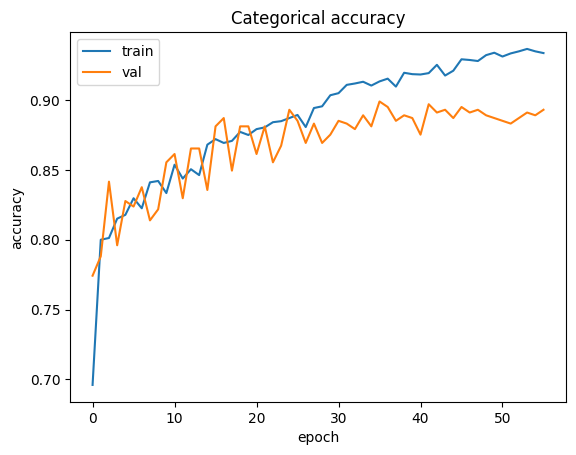

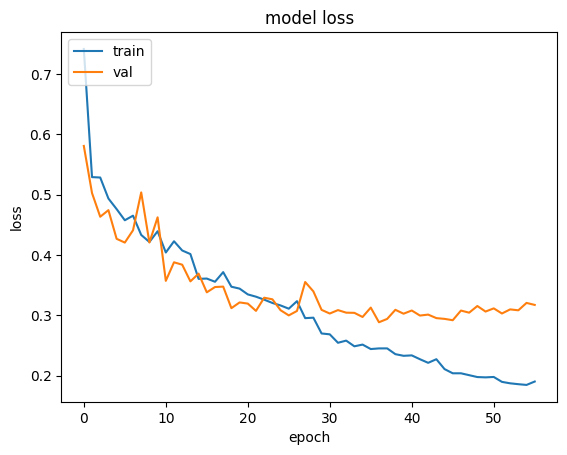

In [62]:
import matplotlib.pyplot as plt

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load the previously saved weights:

In [63]:
## load the previously saved weights
model.load_weights(model_path)

Evaluate on the test set:

In [64]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4502710998058319
Test accuracy: 0.8498023748397827


Perform predictions on the test set and calculate the confusion matrix:

In [65]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred,1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

16/16 [==============================] - 2s 15ms/step
[[252   7  23   0]
 [ 35  22   0   0]
 [ 11   0 152   0]
 [  0   0   0   4]]


Function to predict for an external audio:

In [71]:
classes = np.asarray(classes)

def predict_framewise(x, frame_duration, chunksize=chunksize, model=model):
    # preprocess the input audio
    # 1. split into frames
    x = np.asarray(preprocess(x, int(frame_duration*sample_rate))).astype('float32')
    # 2. extract features for each frame
    new_x = []
    for x_slice in x:
        new_x_slice = np.squeeze(preprocess(x_slice, chunksize))
        features = get_functionals(new_x_slice)
        new_x.append(features)
    x = np.asarray(new_x)
    # print(np.shape(x))        # for debugging

    # feed it into the model to produce predictions
    y_pred = model.predict(x)
    y_pred_probs = np.max(y_pred, axis=1)   # the probability of the highest scoring class
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_pred_labels = classes[y_pred_categorical]   # the label of the highest scoring class
    return y_pred_labels, y_pred_probs

A plotter to plot the prediction result for the audio:

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter

class TimescalePlotter:
    def __init__(self, time_values:list, label_values:list, prob_values:list, filename:str, gold_label:str, color_map={'coughing': 'red', 'sneezing': 'blue', 'speech': 'green', 'silence': 'grey'}):
        data = {
            'Time': time_values,
            'Label': label_values,
            'Probability': prob_values,
        }
        if len(time_values) != len(label_values):
            print(len(time_values))
            print(len(label_values))
        self.df = pd.DataFrame(data)
        self.color_map = color_map
        self.intervals = self._get_intervals()
        self.merged_intervals = self._merge_intervals()     # neglecting probs
        self.title = "Gold label: "+gold_label
        self.filename = filename[:-4]

    def _merge_intervals(self):
        merged_intervals = []
        current_label = self.df['Label'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            if self.df['Label'].iloc[i] != current_label:
                merged_intervals.append((start_time, self.df['Time'].iloc[i], current_label))
                current_label = self.df['Label'].iloc[i]
                start_time = self.df['Time'].iloc[i]

        # Add the last interval
        merged_intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label))
        return merged_intervals

    def _get_intervals(self):
        intervals = []
        current_label = self.df['Label'].iloc[0]
        current_prob = self.df['Probability'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            intervals.append((start_time, self.df['Time'].iloc[i], current_label, current_prob))
            current_label = self.df['Label'].iloc[i]
            current_prob = self.df['Probability'].iloc[i]
            start_time = self.df['Time'].iloc[i]

        # Add the last interval
        intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label, current_prob))
        return intervals

    def plot(self, figsize=(20, 2)):
        fig, ax = plt.subplots(figsize=figsize)  # Adjust the height by setting figsize to (width, height)

        ## Add colored intervals regardless of probabilities
        # for start_time, end_time, label in self.merged_intervals:
        #     ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=0.3, label=label)

        # Add colored intervals with transparencies corresponding to probabilities
        for start_time, end_time, label, prob in self.intervals:
            ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=prob, label=label)

        # Add dummy entries for labels not present in data
        for label, color in self.color_map.items():
            if label not in self.df['Label'].unique():
                ax.axvspan(np.NaN, np.NaN, color=color, alpha=0.3, label=label)

        # Formatting the plot
        ax.set_xlim(self.df['Time'].min() - 1, self.df['Time'].max() + 2)  # Adjust x-axis limits
        ax.set_ylim(0.5, 1.5)  # Adjust y-axis limits to focus on the labels
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Label')
        ax.set_title(self.title)  # Set the plot title

        # Customizing ticks and grid
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show up to 10 major ticks on the x-axis
        ax.yaxis.set_visible(False)  # Hide y-axis
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

        # Create a legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        # Display the plot
        plt.show()

Test an example of an external audio:

3/3 [==============================] - 0s 15ms/step
['speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'coughing'
 'coughing' 'speech' 'speech' 'speech' 'speech' 'coughing' 'speech'
 'speech' 'coughing' 'coughing' 'speech' 'silence' 'coughing' 'coughing'
 'coughing' 'coughing' 'speech' 'speech' 'coughing' 'coughing' 'silence'
 'silence' 'coughing' 'coughing' 'coughing' 'coughing' 'speech' 'speech'
 'coughing' 'coughing' 'speech' 'speech' 'speech' 'coughing' 'speech'
 'sneezing' 'coughing' 'speech' 'speech' 'silence' 'coughing' 'speech'
 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech'
 'speech' 'coughing' 'speech' 'speech' 'coughing' 'speech' 'speech'
 'speech' 'speech' 'coughing' 'speech' 'speech' 'silence' 'silence']
[0.9969677  0.98090446 0.9987115  0.99953526 0.9999246  0.9997604
 0.9843498  0.71404773 0.8787587  0.9999922  0.99989754 0.93352646
 0.9999091  0.85493743 0.9831494  0.99968946 0.8108107  0.97259456
 0.6362674  0.90242743 0.51709425 0

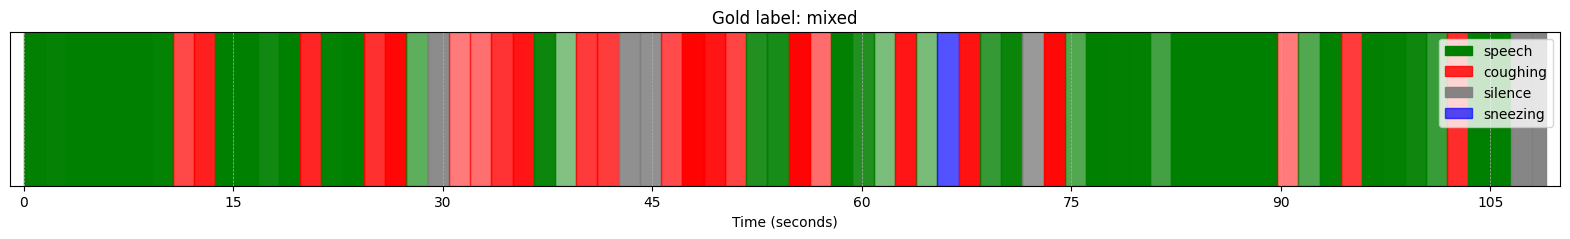

In [73]:
# testing
eg_label = "mixed"
eg_filename = "qPo0bymnsh0.wav"
eg_f = os.path.join(directory, eg_label, eg_filename)
eg_x, eg_sr = librosa.load(eg_f)

frame_duration = 1.5   # in seconds
eg_y_labels, eg_y_probs = predict_framewise(eg_x, frame_duration)
print(eg_y_labels)
print(eg_y_probs)

eg_audio_duration = frame_duration*len(eg_y_labels)
eg_timestamps = np.linspace(start=0, stop=eg_audio_duration, num=len(eg_y_labels))
plotter = TimescalePlotter(list(eg_timestamps), list(eg_y_labels), list(eg_y_probs), eg_filename, eg_label)
plotter.plot()


Observations:

*   Feature extraction takes much longer time.
*   But the model seems to generalise much better on the demo continuous sample with a frame duration of 1.5 seconds, comparing with previously trained models of other structures with frame duration = 1 second.